In [20]:
import FTIR_functions as FTIR
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c as C
from scipy import interpolate as spinter, optimize as spopt

import ipywidgets as widgets
from IPython.display import display

plt.rcParams.update({"image.cmap": 'Greys_r', 'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True, "font.size": 16})

In [21]:
############# STEP 0 : OPEN IMAGE FILE ##################

source = "ir" # Source nickname as it appears in the file name. "blue" "green" "red" "FBH800" "ir" "FBH1600" "big"
run = 8
file_type = ".tif"
ref = 0 # Referance image. This image will be processed into the spectrum

fringes, beamA, beamB, background = FTIR.import_standard_photo(source, run, file_type)

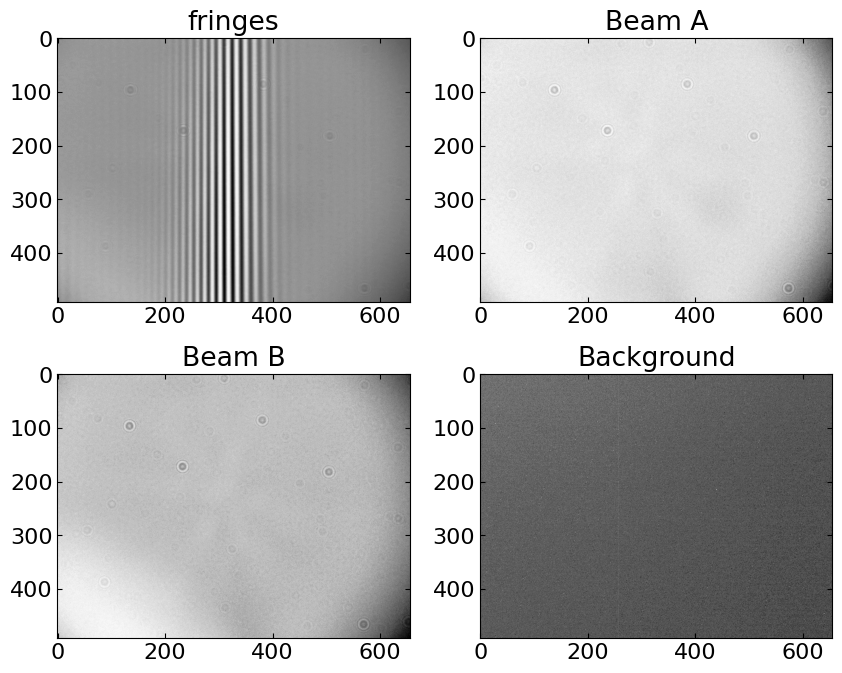

In [22]:
fig, axs = plt.subplots(2, 2, figsize= (10,8))
axs = axs.flatten()

im = axs[0].imshow(fringes[:,:,ref])
axs[0].set(title= "fringes")

axs[1].imshow(beamA)
axs[1].set(title= "Beam A")

axs[2].imshow(beamB)
axs[2].set(title= "Beam B")

axs[3].imshow(background)
axs[3].set(title= "Background")

plt.show()

In [23]:
########### STEP 1: BACKGROUND SUBTRACT ############

fringes_subtracted, no_fringes = FTIR.bg_subtract(fringes, beamA, beamB, background, dead_pixels= 0)
fringes_subtracted = fringes_subtracted[1:,:,:]

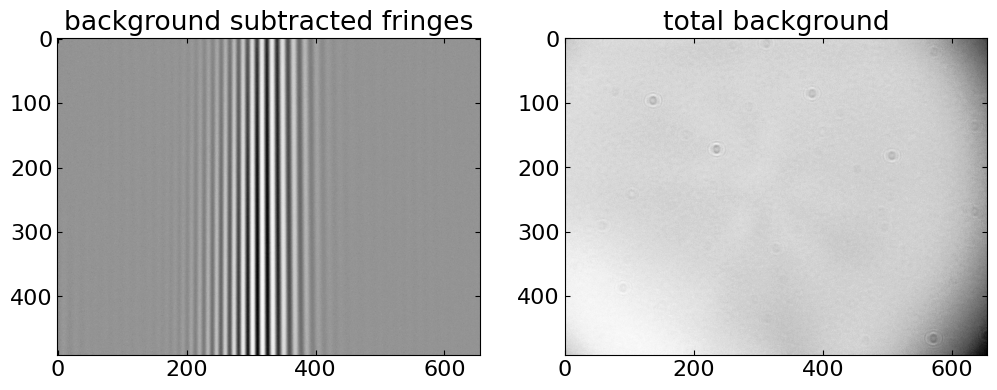

In [24]:
fig, axs = plt.subplots(1, 2, figsize= (12,6))

im = axs[0].imshow(fringes_subtracted[:,:,ref])
axs[0].set(title= "background subtracted fringes")

im = axs[1].imshow(no_fringes[:,:,ref])
axs[1].set(title= "total background")

plt.show()

In [25]:
########### STEP 2: MAKE 1D #############

camera = "xeva" # camera nickname. "manta" "xeva" "purple" "pyro"

if camera == "manta":
    pixel_pitch = 9.9 #um
elif camera == "xeva":
    pixel_pitch = 20 #um
elif camera == "purple":
    pixel_pitch = 48.5 #um
elif camera == "pyro":
    pixel_pitch = 80 #um
else:
    raise ValueError(camera + " is not a valid camera.")

rows, columns = fringes_subtracted[:,:,ref].shape

cam_length = columns*pixel_pitch*1e-3 # in mm
cam_height = rows*pixel_pitch*1e-3 # in mm

FT2d = np.fft.fftshift(np.fft.fft2(fringes_subtracted[:,:,ref], norm= "forward"))

k_x = np.fft.fftshift(np.fft.fftfreq(columns, pixel_pitch*1e-3)) #in mm^-1
k_y = np.fft.fftshift(np.fft.fftfreq(rows, pixel_pitch*1e-3))

dk_x = 1 /(rows*pixel_pitch*1e-3)
dk_y = 1 /(columns*pixel_pitch*1e-3)


In [26]:
cam_extent=  (-pixel_pitch*1e-3/2, cam_length +pixel_pitch*1e-3/2,
              -pixel_pitch*1e-3/2, cam_height +pixel_pitch*1e-3/2)

k_extent= (k_x[0] -dk_x/2, k_x[-1] +dk_x/2,
           k_y[0] -dk_y/2, k_y[-1] +dk_y/2)

# Define the function to plot
def plot_function(alpha):
    fig, axs = plt.subplots(1, 3, figsize= (18,6))

    x_intercepts, y_intercepts, _ = FTIR.bounding_box((0, cam_length), (0, cam_height), (cam_length/2, cam_height/2), np.tan(alpha))

    axs[0].imshow(fringes_subtracted[:,:,ref], origin= "lower", extent= cam_extent)
    axs[0].plot(x_intercepts, y_intercepts)
    axs[0].set(title= "background subtracted fringes", xlabel= "displacement $x$ (mm)", ylabel= "displacement $y$ (mm)")

    k_x_intercepts, k_y_intercepts, _ = FTIR.bounding_box((k_x[0], k_x[-1]), (k_y[0], k_y[-1]), (0,0), np.tan(alpha))

    axs[1].imshow(np.abs(FT2d), origin= "lower", extent= k_extent, cmap= "magma_r")
    axs[1].plot(0, 0, color= "k", marker= "+", markersize= 16) #crosshair
    axs[1].plot(k_x_intercepts, k_y_intercepts)
    axs[1].set(title= "2D fourier transform", xlabel= "wavenumber $x$ (mm$^{-1}$)", ylabel= "wavenumber $y$ (mm$^{-1}$)")

    fringes_1d, _ = FTIR.slice_2d(fringes_subtracted[:,:,ref], alpha)
    fringes_1d = FTIR.recenter(fringes_1d)

    axs[2].plot(fringes_1d) # WHAT IS THE X AXIS??

    plt.show()

### interactive alpha
decimal_places = 1
alpha_slider = widgets.BoundedFloatText(value=0.0, min=np.round(-np.pi/2, decimal_places), max=np.round(np.pi/2, decimal_places), step= 10**-decimal_places, description='alpha (rad):', disabled= False)

### auto button
auto_button = widgets.Button(description='Auto', button_style='info')
def auto_values(button):
    alpha_slider.value = FTIR.find_alpha(fringes_subtracted[:,:,ref])  # Set the slider value to a predefined value
auto_button.on_click(auto_values)

### display widgets and interactive plot
interactive_plot = widgets.interact(plot_function, alpha=alpha_slider)
display(auto_button)


interactive(children=(BoundedFloatText(value=0.0, description='alpha (rad):', max=1.6, min=-1.6, step=0.1), Ou…

Button(button_style='info', description='Auto', style=ButtonStyle())

In [33]:
########### STEP 3: APODIZATION #############

alpha = alpha_slider.value

fringes_1d, _ = FTIR.slice_2d(fringes_subtracted[:,:,ref], alpha)
fringes_1d = FTIR.recenter(fringes_1d)

fringes_apodized = FTIR.apodization(fringes_1d, function= ["happ-genzel"])


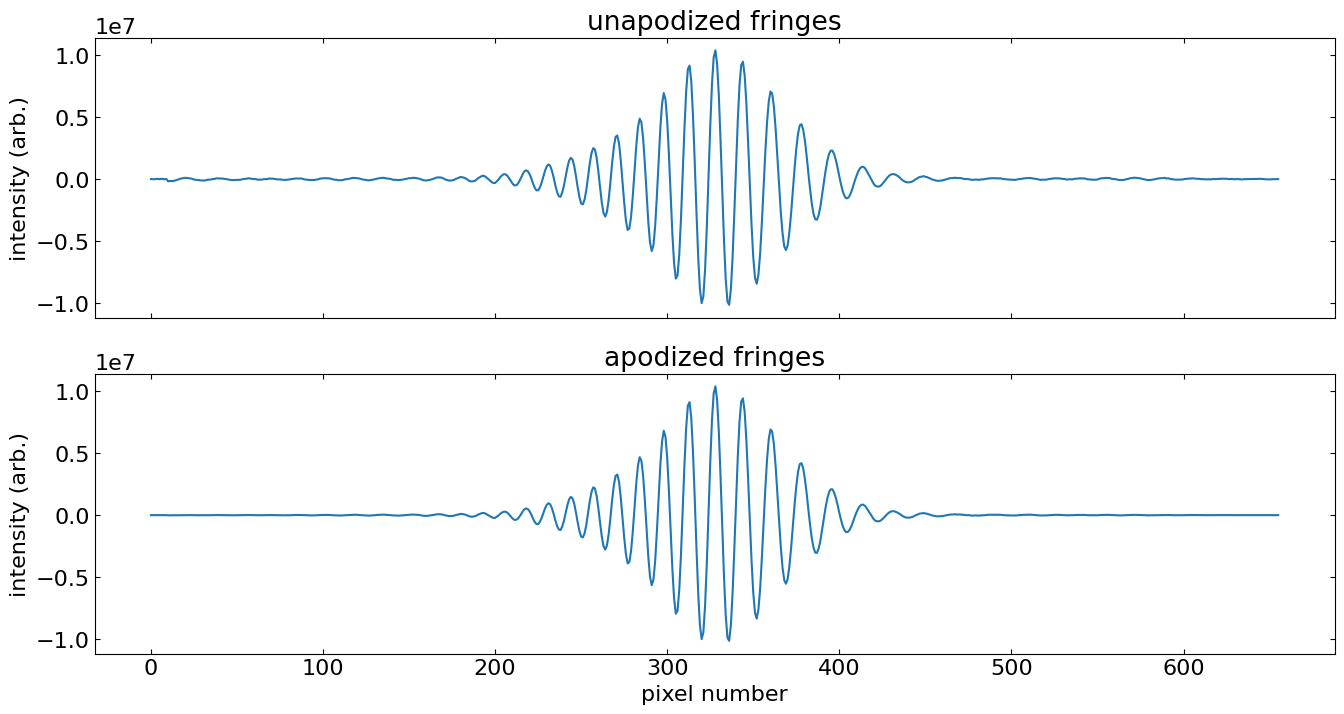

In [34]:
fig, axs = plt.subplots(2, 1, figsize= (16, 8), sharex= True)

axs[0].plot(fringes_1d)
axs[0].set(ylabel= "intensity (arb.)", title= "unapodized fringes")

axs[1].plot(fringes_apodized)
axs[1].set(xlabel= "pixel number", ylabel= "intensity (arb.)", title= "apodized fringes")

plt.show()

In [35]:
########### STEP 4: ZERO PADDING #############

zero_padding = 4 # Make the interferogram `zero_padding` times longer by adding zeros to the start and end

fringes_padded = FTIR.zero_pad(fringes_apodized, zero_padding= zero_padding)

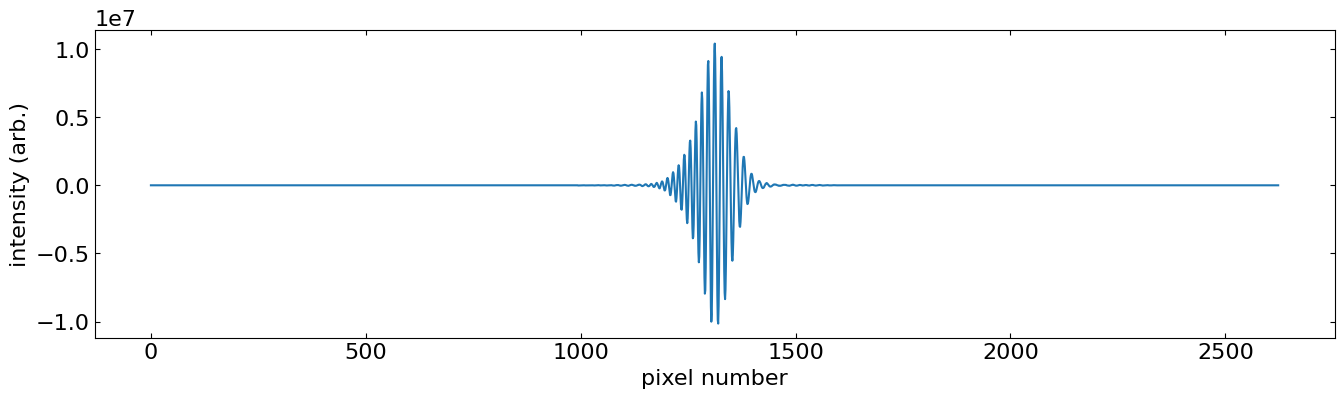

In [36]:
fig, axs = plt.subplots(1, 1, figsize= (16, 4))

axs.plot(fringes_padded)
axs.set(xlabel= "pixel number", ylabel= "intensity (arb.)")

plt.show()

In [37]:
########### STEP 5: FOURIER TRANSFORM #############

theta = 10 #arcminutes

spectrum, freqs = FTIR.power_spectrum_FT(fringes_padded, theta, pixel_pitch)

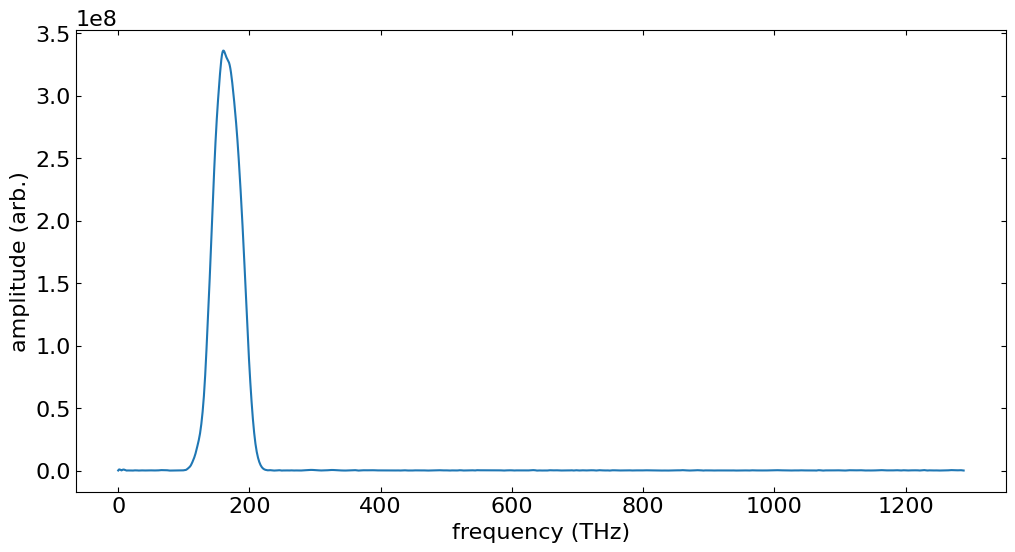

In [38]:
fig, axs = plt.subplots(1, 1, figsize= (12, 6))

axs.plot(freqs*1e-12, spectrum)
axs.set(xlabel= "frequency (THz)", ylabel= "amplitude (arb.)")

plt.show()